# MODELO DE REGRESION LINEAL

Forma del conjunto de datos original: (301, 9)


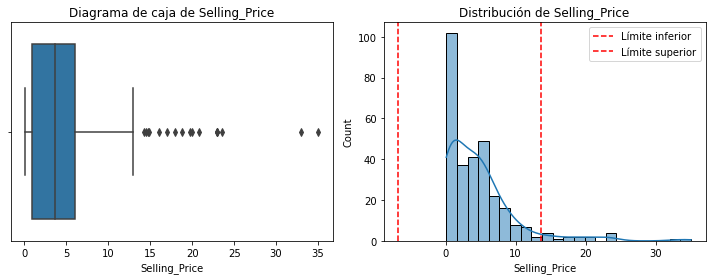


Valores atípicos en Selling_Price:
Número de valores atípicos: 17
Porcentaje de valores atípicos: 5.65%


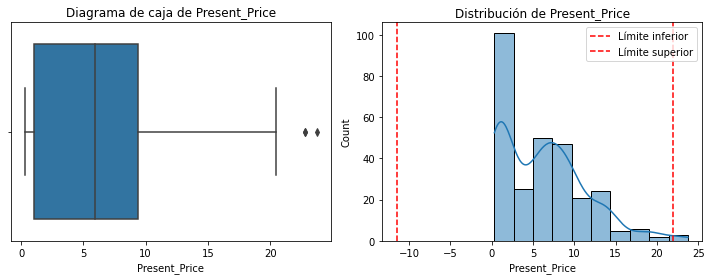


Valores atípicos en Present_Price:
Número de valores atípicos: 3
Porcentaje de valores atípicos: 1.06%


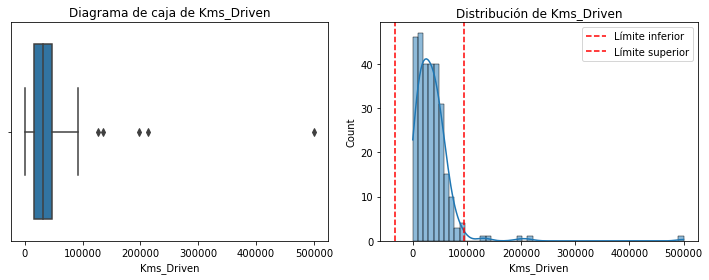


Valores atípicos en Kms_Driven:
Número de valores atípicos: 5
Porcentaje de valores atípicos: 1.78%

Forma del conjunto de datos después de eliminar valores atípicos: (276, 13)
Registros eliminados: 25

Características seleccionadas: ['Year', 'Present_Price', 'Kms_Driven', 'Fuel_Type_Encoded', 'Seller_Type_Encoded']

Métricas de rendimiento del modelo:
Puntuación R²: 0.8429
Error absoluto medio: 0.8886


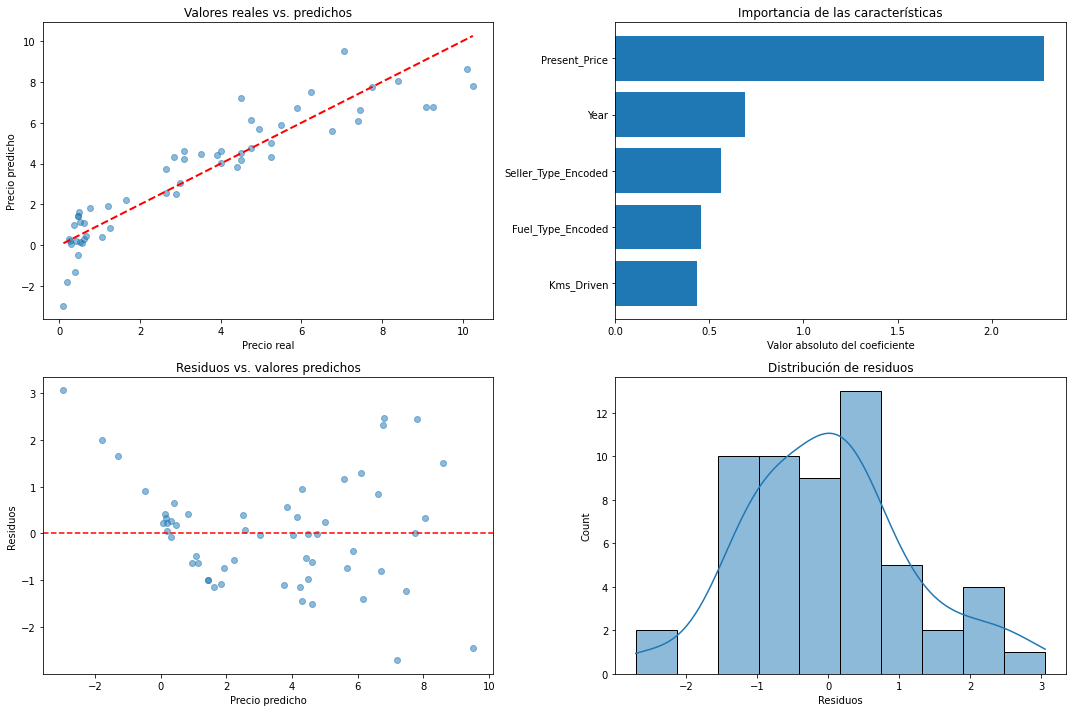

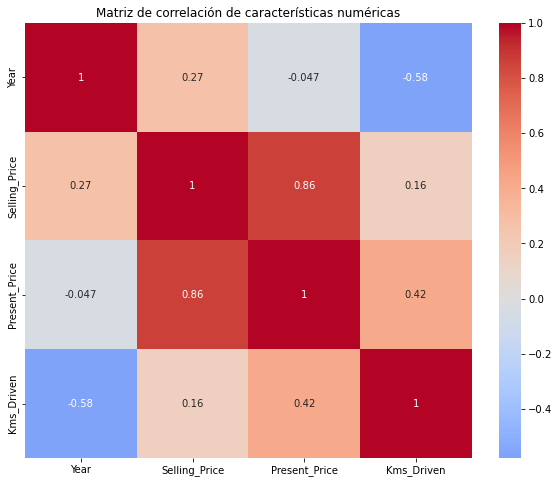


Coeficientes de características:
Year: 0.6917
Present_Price: 2.2790
Kms_Driven: -0.4333
Fuel_Type_Encoded: -0.4555
Seller_Type_Encoded: -0.5638

Resumen de mejora del modelo:
1. El modelo ahora usa un conjunto de datos limpio con valores atípicos eliminados
2. Número de registros eliminados: 25
3. Tamaño final del conjunto de datos: 276 registros
4. Puntuación R²: 0.8429
5. Error absoluto medio: 0.8886


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression

# 1. Cargar y explorar los datos
df = pd.read_csv('car data.csv')

# Exploración inicial EDA:
print("Forma del conjunto de datos original:", df.shape)

# 2. Preprocesamiento de datos
# Convertir variables categóricas usando Label Encoding
le = LabelEncoder()
categorical_cols = ['Car_Name', 'Fuel_Type', 'Seller_Type', 'Transmission']
for col in categorical_cols:
    df[col + '_Encoded'] = le.fit_transform(df[col])

# Eliminar valores atípicos.
def remove_outliers(df, columns):
    df_clean = df.copy()
    
    for column in columns:
        Q1 = df_clean[column].quantile(0.25)
        Q3 = df_clean[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Crear gráficos de valores atípicos antes de eliminarlos
        plt.figure(figsize=(10, 4))
        
        # Diagrama de caja
        plt.subplot(1, 2, 1)
        sns.boxplot(x=df_clean[column])
        plt.title(f'Diagrama de caja de {column}')
        
        # Gráfico de distribución
        plt.subplot(1, 2, 2)
        sns.histplot(df_clean[column], kde=True)
        plt.axvline(lower_bound, color='r', linestyle='--', label='Límite inferior')
        plt.axvline(upper_bound, color='r', linestyle='--', label='Límite superior')
        plt.title(f'Distribución de {column}')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
        
        # Mostrar la información de los valores atípicos
        outliers = df_clean[(df_clean[column] < lower_bound) | (df_clean[column] > upper_bound)]
        print(f"\nValores atípicos en {column}:")
        print(f"Número de valores atípicos: {len(outliers)}")
        print(f"Porcentaje de valores atípicos: {(len(outliers)/len(df_clean)*100):.2f}%")
        
        # Eliminar valores atípicos
        df_clean = df_clean[(df_clean[column] >= lower_bound) & (df_clean[column] <= upper_bound)]
    
    return df_clean

# Eliminar valores atípicos de columnas numéricas
numerical_columns = ['Selling_Price', 'Present_Price', 'Kms_Driven']
df_clean = remove_outliers(df, numerical_columns)

print("\nForma del conjunto de datos después de eliminar valores atípicos:", df_clean.shape)
print(f"Registros eliminados: {len(df) - len(df_clean)}")

# Crear matriz de relación:
features = ['Year', 'Present_Price', 'Kms_Driven', 'Owner', 
            'Fuel_Type_Encoded', 'Seller_Type_Encoded', 'Transmission_Encoded']
X = df_clean[features]
y = df_clean['Selling_Price']

# Escalar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=features)

# 3. Selección de características
selector = SelectKBest(score_func=f_regression, k=5)
X_selected = selector.fit_transform(X_scaled, y)
selected_features_mask = selector.get_support()
selected_features = X_scaled.columns[selected_features_mask].tolist()
print("\nCaracterísticas seleccionadas:", selected_features)

# 4. Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42
)

# 5. 
model = LinearRegression()
model.fit(X_train, y_train)

# 6. Hacer predicciones y evaluar
y_pred = model.predict(X_test)

# Calcular métricas
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("\nMétricas de rendimiento del modelo:")
print(f"Puntuación R²: {r2:.4f}")
print(f"Error absoluto medio: {mae:.4f}")

# 7. Visualizaciones
plt.figure(figsize=(15, 10))

# Valores reales vs. predichos
plt.subplot(2, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Precio real')
plt.ylabel('Precio predicho')
plt.title('Valores reales vs. predichos')

# Importancia de las características
plt.subplot(2, 2, 2)
feature_importance = pd.DataFrame({
    'feature': selected_features,
    'importance': abs(model.coef_)
})
feature_importance = feature_importance.sort_values('importance', ascending=True)
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Valor absoluto del coeficiente')
plt.title('Importancia de las características')

# Gráfico de residuos
plt.subplot(2, 2, 3)
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.5)
plt.xlabel('Precio predicho')
plt.ylabel('Residuos')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuos vs. valores predichos')

# Distribución de residuos
plt.subplot(2, 2, 4)
sns.histplot(residuals, kde=True)
plt.xlabel('Residuos')
plt.title('Distribución de residuos')

plt.tight_layout()
plt.show()

# 8. Análisis adicional
# Matriz de correlación para características numéricas
numerical_features = ['Year', 'Selling_Price', 'Present_Price', 'Kms_Driven']
correlation_matrix = df_clean[numerical_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de correlación de características numéricas')
plt.show()

# Imprimir coeficientes de características
print("\nCoeficientes de características:")
for feature, coef in zip(selected_features, model.coef_):
    print(f"{feature}: {coef:.4f}")

# Comparar el rendimiento del modelo antes y después de la eliminación de valores atípicos
print("\nResumen de mejora del modelo:")
print("1. El modelo ahora usa un conjunto de datos limpio con valores atípicos eliminados")
print(f"2. Número de registros eliminados: {len(df) - len(df_clean)}")
print(f"3. Tamaño final del conjunto de datos: {len(df_clean)} registros")
print(f"4. Puntuación R²: {r2:.4f}")
print(f"5. Error absoluto medio: {mae:.4f}")
